# Method 5 - Best Minus Rest

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()                                                                           
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

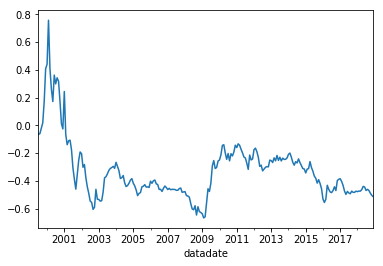

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.407638
2000-12-31   -0.307609
2001-12-31   -0.170500
2002-12-31   -0.420660
2003-12-31    0.474838
2004-12-31   -0.107497
2005-12-31   -0.102915
2006-12-31   -0.002661
2007-12-31   -0.055844
2008-12-31   -0.285004
2009-12-31    0.995669
2010-12-31    0.153721
2011-12-31   -0.116451
2012-12-31   -0.009975
2013-12-31    0.020477
2014-12-31   -0.103815
2015-12-31   -0.207043
2016-12-31    0.124784
2017-12-31   -0.139807
2018-12-31   -0.076760
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     93.70
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.43e-47
Time:                        04:24:17   Log-Likelihood:                 378.67
No. Observations:                 234   AIC:                            -747.3
Df Residuals:                     229   BIC:                            -730.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.003      0.855      0.393      -0.004       0.009
mktrf          0.3317      0.090      3.668      0.000       0.154       0.510
me             0.3771      0.105      3.585      0.000       0.170       0.584
ia            -0.2515      0.160     -1.573      0.117      -0.567       0.064
roe           -1.4539      0.137    -10.623      0.000      -1.724      -1.184
==============================================================================
Omnibus:                      134.044   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1590.610
Skew:                           1.969   Prob(JB):                         0.00
Kurtosis:                      15.150   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     100.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.13e-49
Time:                        04:24:17   Log-Likelihood:                 378.67
No. Observations:                 234   AIC:                            -747.3
Df Residuals:                     229   BIC:                            -730.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.003      0.857      0.392      -0.004       0.009
mktrf          0.3317      0.163      2.038      0.042       0.013       0.651
me             0.3771      0.131      2.888      0.004       0.121       0.633
ia            -0.2515      0.232     -1.082      0.279      -0.707       0.204
roe           -1.4539      0.197     -7.377      0.000      -1.840      -1.068
==============================================================================
Omnibus:                      134.044   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1590.610
Skew:                           1.969   Prob(JB):                         0.00
Kurtosis:                      15.150   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     112.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.20e-53
Time:                        04:24:17   Log-Likelihood:                 378.67
No. Observations:                 234   AIC:                            -747.3
Df Residuals:                     229   BIC:                            -730.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.004      0.777      0.437      -0.004       0.010
mktrf          0.3317      0.161      2.055      0.040       0.015       0.648
me             0.3771      0.140      2.689      0.007       0.102       0.652
ia            -0.2515      0.242     -1.040      0.298      -0.725       0.222
roe           -1.4539      0.207     -7.032      0.000      -1.859      -1.049
==============================================================================
Omnibus:                      134.044   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1590.610
Skew:                           1.969   Prob(JB):                         0.00
Kurtosis:                      15.150   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     64.84
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.81e-42
Time:                        04:24:17   Log-Likelihood:                 368.72
No. Observations:                 234   AIC:                            -725.4
Df Residuals:                     228   BIC:                            -704.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.606      0.545      -0.005       0.009
mktrf          0.4626      0.095      4.882      0.000       0.276       0.649
smb            0.3601      0.125      2.880      0.004       0.114       0.606
hml            0.1286      0.147      0.872      0.384      -0.162       0.419
rmw           -1.3964      0.167     -8.377      0.000      -1.725      -1.068
cma           -0.0489      0.212     -0.231      0.818      -0.466       0.369
==============================================================================
Omnibus:                      140.523   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1141.030
Skew:                           2.270   Prob(JB):                    1.69e-248
Kurtosis:                      12.819   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     45.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.93e-32
Time:                        04:24:17   Log-Likelihood:                 368.72
No. Observations:                 234   AIC:                            -725.4
Df Residuals:                     228   BIC:                            -704.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.573      0.567      -0.005       0.009
mktrf          0.4626      0.117      3.958      0.000       0.234       0.692
smb            0.3601      0.113      3.180      0.001       0.138       0.582
hml            0.1286      0.224      0.573      0.567      -0.311       0.569
rmw           -1.3964      0.210     -6.653      0.000      -1.808      -0.985
cma           -0.0489      0.318     -0.154      0.878      -0.671       0.574
==============================================================================
Omnibus:                      140.523   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1141.030
Skew:                           2.270   Prob(JB):                    1.69e-248
Kurtosis:                      12.819   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     46.98
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.94e-33
Time:                        04:24:17   Log-Likelihood:                 368.72
No. Observations:                 234   AIC:                            -725.4
Df Residuals:                     228   BIC:                            -704.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.512      0.609      -0.006       0.010
mktrf          0.4626      0.105      4.417      0.000       0.257       0.668
smb            0.3601      0.114      3.146      0.002       0.136       0.584
hml            0.1286      0.174      0.740      0.459      -0.212       0.469
rmw           -1.3964      0.213     -6.560      0.000      -1.814      -0.979
cma           -0.0489      0.304     -0.161      0.872      -0.645       0.547
==============================================================================
Omnibus:                      140.523   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1141.030
Skew:                           2.270   Prob(JB):                    1.69e-248
Kurtosis:                      12.819   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     77.81
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.40e-41
Time:                        04:24:17   Log-Likelihood:                 365.66
No. Observations:                 234   AIC:                            -721.3
Df Residuals:                     229   BIC:                            -704.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.003     -0.642      0.522      -0.009       0.005
mktrf          0.5602      0.088      6.364      0.000       0.387       0.734
smb            1.0383      0.110      9.449      0.000       0.822       1.255
hml           -0.3235      0.109     -2.964      0.003      -0.539      -0.108
umd           -0.5400      0.072     -7.540      0.000      -0.681      -0.399
==============================================================================
Omnibus:                      121.331   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1056.887
Skew:                           1.837   Prob(JB):                    3.16e-230
Kurtosis:                      12.742   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     37.95
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.41e-24
Time:                        04:24:17   Log-Likelihood:                 365.66
No. Observations:                 234   AIC:                            -721.3
Df Residuals:                     229   BIC:                            -704.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.003     -0.753      0.451      -0.008       0.004
mktrf          0.5602      0.140      4.012      0.000       0.287       0.834
smb            1.0383      0.136      7.653      0.000       0.772       1.304
hml           -0.3235      0.167     -1.937      0.053      -0.651       0.004
umd           -0.5400      0.115     -4.676      0.000      -0.766      -0.314
==============================================================================
Omnibus:                      121.331   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1056.887
Skew:                           1.837   Prob(JB):                    3.16e-230
Kurtosis:                      12.742   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     39.39
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.39e-25
Time:                        04:24:17   Log-Likelihood:                 365.66
No. Observations:                 234   AIC:                            -721.3
Df Residuals:                     229   BIC:                            -704.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.003     -0.740      0.459      -0.008       0.004
mktrf          0.5602      0.133      4.211      0.000       0.300       0.821
smb            1.0383      0.130      7.958      0.000       0.783       1.294
hml           -0.3235      0.170     -1.902      0.057      -0.657       0.010
umd           -0.5400      0.114     -4.753      0.000      -0.763      -0.317
==============================================================================
Omnibus:                      121.331   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1056.887
Skew:                           1.837   Prob(JB):                    3.16e-230
Kurtosis:                      12.742   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     50.86
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.39e-24
Time:                        04:24:17   Log-Likelihood:                 173.69
No. Observations:                 120   AIC:                            -337.4
Df Residuals:                     115   BIC:                            -323.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.006      1.229      0.222      -0.004       0.018
mktrf          0.1938      0.150      1.293      0.199      -0.103       0.491
me             0.3110      0.148      2.101      0.038       0.018       0.604
ia            -0.5540      0.232     -2.391      0.018      -1.013      -0.095
roe           -1.4954      0.205     -7.291      0.000      -1.902      -1.089
==============================================================================
Omnibus:                       60.212   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.636
Skew:                           1.582   Prob(JB):                     5.36e-76
Kurtosis:                      10.702   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     128.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.00e-41
Time:                        04:24:17   Log-Likelihood:                 173.69
No. Observations:                 120   AIC:                            -337.4
Df Residuals:                     115   BIC:                            -323.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.005      1.408      0.159      -0.003       0.016
mktrf          0.1938      0.241      0.806      0.420      -0.278       0.665
me             0.3110      0.167      1.865      0.062      -0.016       0.638
ia            -0.5540      0.308     -1.801      0.072      -1.157       0.049
roe           -1.4954      0.274     -5.457      0.000      -2.033      -0.958
==============================================================================
Omnibus:                       60.212   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.636
Skew:                           1.582   Prob(JB):                     5.36e-76
Kurtosis:                      10.702   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     174.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.35e-48
Time:                        04:24:17   Log-Likelihood:                 173.69
No. Observations:                 120   AIC:                            -337.4
Df Residuals:                     115   BIC:                            -323.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.005      1.371      0.170      -0.003       0.017
mktrf          0.1938      0.238      0.814      0.416      -0.273       0.660
me             0.3110      0.179      1.735      0.083      -0.040       0.662
ia            -0.5540      0.302     -1.835      0.066      -1.146       0.038
roe           -1.4954      0.303     -4.938      0.000      -2.089      -0.902
==============================================================================
Omnibus:                       60.212   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.636
Skew:                           1.582   Prob(JB):                     5.36e-76
Kurtosis:                      10.702   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     36.09
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.30e-22
Time:                        04:24:17   Log-Likelihood:                 169.52
No. Observations:                 120   AIC:                            -327.0
Df Residuals:                     114   BIC:                            -310.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.006      1.220      0.225      -0.005       0.019
mktrf          0.4749      0.164      2.890      0.005       0.149       0.800
smb            0.3277      0.186      1.761      0.081      -0.041       0.696
hml           -0.1732      0.228     -0.759      0.449      -0.625       0.279
rmw           -1.2160      0.269     -4.522      0.000      -1.749      -0.683
cma           -0.0927      0.295     -0.315      0.754      -0.676       0.491
==============================================================================
Omnibus:                       76.613   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              374.897
Skew:                           2.264   Prob(JB):                     3.91e-82
Kurtosis:                      10.381   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     37.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.26e-22
Time:                        04:24:17   Log-Likelihood:                 169.52
No. Observations:                 120   AIC:                            -327.0
Df Residuals:                     114   BIC:                            -310.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.005      1.474      0.140      -0.002       0.017
mktrf          0.4749      0.210      2.256      0.024       0.062       0.887
smb            0.3277      0.176      1.866      0.062      -0.017       0.672
hml           -0.1732      0.168     -1.030      0.303      -0.503       0.156
rmw           -1.2160      0.303     -4.018      0.000      -1.809      -0.623
cma           -0.0927      0.358     -0.259      0.796      -0.795       0.609
==============================================================================
Omnibus:                       76.613   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              374.897
Skew:                           2.264   Prob(JB):                     3.91e-82
Kurtosis:                      10.381   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     45.87
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.42e-26
Time:                        04:24:17   Log-Likelihood:                 169.52
No. Observations:                 120   AIC:                            -327.0
Df Residuals:                     114   BIC:                            -310.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.005      1.358      0.174      -0.003       0.018
mktrf          0.4749      0.175      2.720      0.007       0.133       0.817
smb            0.3277      0.167      1.963      0.050       0.001       0.655
hml           -0.1732      0.118     -1.464      0.143      -0.405       0.059
rmw           -1.2160      0.318     -3.830      0.000      -1.838      -0.594
cma           -0.0927      0.332     -0.280      0.780      -0.742       0.557
==============================================================================
Omnibus:                       76.613   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              374.897
Skew:                           2.264   Prob(JB):                     3.91e-82
Kurtosis:                      10.381   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     52.06
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.94e-25
Time:                        04:24:17   Log-Likelihood:                 174.59
No. Observations:                 120   AIC:                            -339.2
Df Residuals:                     115   BIC:                            -325.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.005      0.280      0.780      -0.009       0.012
mktrf          0.5547      0.131      4.234      0.000       0.295       0.814
smb            0.9916      0.149      6.647      0.000       0.696       1.287
hml           -0.6446      0.149     -4.314      0.000      -0.940      -0.349
umd           -0.5209      0.092     -5.655      0.000      -0.703      -0.338
==============================================================================
Omnibus:                       65.694   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.776
Skew:                           1.724   Prob(JB):                     1.16e-91
Kurtosis:                      11.477   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     51.54
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.53e-25
Time:                        04:24:17   Log-Likelihood:                 174.59
No. Observations:                 120   AIC:                            -339.2
Df Residuals:                     115   BIC:                            -325.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.004      0.385      0.701      -0.006       0.009
mktrf          0.5547      0.203      2.726      0.006       0.156       0.954
smb            0.9916      0.141      7.024      0.000       0.715       1.268
hml           -0.6446      0.163     -3.962      0.000      -0.963      -0.326
umd           -0.5209      0.118     -4.408      0.000      -0.753      -0.289
==============================================================================
Omnibus:                       65.694   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.776
Skew:                           1.724   Prob(JB):                     1.16e-91
Kurtosis:                      11.477   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     63.55
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.03e-28
Time:                        04:24:17   Log-Likelihood:                 174.59
No. Observations:                 120   AIC:                            -339.2
Df Residuals:                     115   BIC:                            -325.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.004      0.408      0.684      -0.006       0.009
mktrf          0.5547      0.193      2.877      0.004       0.177       0.933
smb            0.9916      0.127      7.834      0.000       0.743       1.240
hml           -0.6446      0.135     -4.792      0.000      -0.908      -0.381
umd           -0.5209      0.121     -4.295      0.000      -0.759      -0.283
==============================================================================
Omnibus:                       65.694   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.776
Skew:                           1.724   Prob(JB):                     1.16e-91
Kurtosis:                      11.477   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     46.74
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.08e-23
Time:                        04:24:17   Log-Likelihood:                 226.03
No. Observations:                 114   AIC:                            -442.1
Df Residuals:                     109   BIC:                            -428.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.498      0.619      -0.008       0.005
mktrf          0.4737      0.100      4.728      0.000       0.275       0.672
me             0.4190      0.155      2.709      0.008       0.112       0.726
ia             0.3608      0.215      1.682      0.096      -0.064       0.786
roe           -1.4192      0.189     -7.528      0.000      -1.793      -1.046
==============================================================================
Omnibus:                       34.083   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.057
Skew:                           1.116   Prob(JB):                     3.39e-19
Kurtosis:                       6.595   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     38.81
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.64e-20
Time:                        04:24:17   Log-Likelihood:                 226.03
No. Observations:                 114   AIC:                            -442.1
Df Residuals:                     109   BIC:                            -428.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.583      0.560      -0.007       0.004
mktrf          0.4737      0.119      3.970      0.000       0.240       0.707
me             0.4190      0.203      2.060      0.039       0.020       0.818
ia             0.3608      0.242      1.488      0.137      -0.114       0.836
roe           -1.4192      0.297     -4.777      0.000      -2.002      -0.837
==============================================================================
Omnibus:                       34.083   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.057
Skew:                           1.116   Prob(JB):                     3.39e-19
Kurtosis:                       6.595   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     46.13
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.26e-22
Time:                        04:24:17   Log-Likelihood:                 226.03
No. Observations:                 114   AIC:                            -442.1
Df Residuals:                     109   BIC:                            -428.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.609      0.543      -0.007       0.004
mktrf          0.4737      0.113      4.185      0.000       0.252       0.695
me             0.4190      0.237      1.768      0.077      -0.046       0.884
ia             0.3608      0.268      1.344      0.179      -0.165       0.887
roe           -1.4192      0.301     -4.723      0.000      -2.008      -0.830
==============================================================================
Omnibus:                       34.083   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.057
Skew:                           1.116   Prob(JB):                     3.39e-19
Kurtosis:                       6.595   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     35.35
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.82e-21
Time:                        04:24:17   Log-Likelihood:                 224.35
No. Observations:                 114   AIC:                            -436.7
Df Residuals:                     108   BIC:                            -420.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -0.893      0.374      -0.010       0.004
mktrf          0.5074      0.097      5.209      0.000       0.314       0.700
smb            0.3780      0.158      2.391      0.019       0.065       0.691
hml            0.7140      0.202      3.540      0.001       0.314       1.114
rmw           -1.2094      0.247     -4.898      0.000      -1.699      -0.720
cma           -0.0172      0.313     -0.055      0.956      -0.639       0.604
==============================================================================
Omnibus:                       24.295   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.471
Skew:                           0.783   Prob(JB):                     2.01e-13
Kurtosis:                       6.140   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     28.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.83e-18
Time:                        04:24:17   Log-Likelihood:                 224.35
No. Observations:                 114   AIC:                            -436.7
Df Residuals:                     108   BIC:                            -420.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.004     -0.787      0.431      -0.011       0.005
mktrf          0.5074      0.089      5.706      0.000       0.333       0.682
smb            0.3780      0.158      2.397      0.017       0.069       0.687
hml            0.7140      0.208      3.424      0.001       0.305       1.123
rmw           -1.2094      0.297     -4.072      0.000      -1.792      -0.627
cma           -0.0172      0.285     -0.060      0.952      -0.576       0.541
==============================================================================
Omnibus:                       24.295   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.471
Skew:                           0.783   Prob(JB):                     2.01e-13
Kurtosis:                       6.140   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     34.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.66e-21
Time:                        04:24:17   Log-Likelihood:                 224.35
No. Observations:                 114   AIC:                            -436.7
Df Residuals:                     108   BIC:                            -420.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.004     -0.802      0.423      -0.011       0.004
mktrf          0.5074      0.090      5.638      0.000       0.331       0.684
smb            0.3780      0.172      2.196      0.028       0.041       0.715
hml            0.7140      0.174      4.094      0.000       0.372       1.056
rmw           -1.2094      0.266     -4.544      0.000      -1.731      -0.688
cma           -0.0172      0.290     -0.059      0.953      -0.586       0.552
==============================================================================
Omnibus:                       24.295   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.471
Skew:                           0.783   Prob(JB):                     2.01e-13
Kurtosis:                       6.140   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     37.98
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.17e-20
Time:                        04:24:17   Log-Likelihood:                 218.85
No. Observations:                 114   AIC:                            -427.7
Df Residuals:                     109   BIC:                            -414.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.004     -1.071      0.287      -0.011       0.003
mktrf          0.5386      0.101      5.327      0.000       0.338       0.739
smb            0.6658      0.158      4.223      0.000       0.353       0.978
hml            0.6613      0.162      4.073      0.000       0.340       0.983
umd           -0.4400      0.122     -3.593      0.000      -0.683      -0.197
==============================================================================
Omnibus:                       30.135   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.901
Skew:                           0.928   Prob(JB):                     6.04e-19
Kurtosis:                       6.770   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     37.21
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.36e-19
Time:                        04:24:17   Log-Likelihood:                 218.85
No. Observations:                 114   AIC:                            -427.7
Df Residuals:                     109   BIC:                            -414.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.161      0.246      -0.010       0.003
mktrf          0.5386      0.099      5.437      0.000       0.344       0.733
smb            0.6658      0.163      4.089      0.000       0.347       0.985
hml            0.6613      0.193      3.433      0.001       0.284       1.039
umd           -0.4400      0.121     -3.637      0.000      -0.677      -0.203
==============================================================================
Omnibus:                       30.135   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.901
Skew:                           0.928   Prob(JB):                     6.04e-19
Kurtosis:                       6.770   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     39.90
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.50e-20
Time:                        04:24:17   Log-Likelihood:                 218.85
No. Observations:                 114   AIC:                            -427.7
Df Residuals:                     109   BIC:                            -414.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.185      0.236      -0.010       0.003
mktrf          0.5386      0.097      5.581      0.000       0.349       0.728
smb            0.6658      0.150      4.432      0.000       0.371       0.960
hml            0.6613      0.194      3.416      0.001       0.282       1.041
umd           -0.4400      0.118     -3.733      0.000      -0.671      -0.209
==============================================================================
Omnibus:                       30.135   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.901
Skew:                           0.928   Prob(JB):                     6.04e-19
Kurtosis:                       6.770   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""